In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import sciann as sn
from sciann import math as snm
import keras

Using TensorFlow backend.


---------------------- SCIANN 0.4.6.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



In [3]:
import sys
sys.path.append('../../')
import src
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils
import src.eikonal as eikonal
from tqdm.notebook import tqdm
import datetime
import pickle

In [4]:
def save(obj, filename, mode='wb'):
    with open(filename, mode) as f:
        pickle.dump(obj, f)
        
def load(filename, mode='rb'):
    with open(filename, mode) as f:
        d = pickle.load(f)
    return d

# Regular grid

In [5]:
nx, nz = 51, 51
xmin, xmax = 0.0, 1000.0
zmin, zmax = 0.0, 1000.0
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)

dx, dz = x[1] - x[0], z[1] - z[0]
XZ = np.array(np.meshgrid(x, z, indexing='ij'))
X, Z = XZ

vmin, vmax = 1000.0, 4000.0
a = (vmax - vmin) / z.max()

In [6]:
# Source
ixs, izs = 25, 25
sid = (ixs, izs)
rav_sid = np.ravel_multi_index(sid, (nx, nz))
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
sou_xz = np.array(sou, ndmin=2)

# Grid
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler

# Velocity
V = eikonal.vel_func(vmin, a)(Z)
V_scaled = V / vmax

# Solution
T = eikonal.t_vgrad(X, Z, xs, zs, vmin, a)

# Indices for additinal bounds
new_inds = np.array([(ixs - 1, izs), (ixs + 1, izs), (ixs, izs - 1), (ixs, izs + 1)])
inds = np.vstack((new_inds, [[ixs, izs]]))
rav_inds = np.ravel_multi_index(inds.T, (nx, nz))

# Gradient
tau_grad = eikonal.t_vfield_vgrad(X, Z, xs, zs, vmin, a)
tau_modul = np.linalg.norm(tau_grad, axis=-1, keepdims=True) + 1e-16
tau_grad /= tau_modul

../..\src\eikonal\helpers.py:87: RuntimeWarning: divide by zero encountered in true_divide
  A = 1 / a / np.sqrt((up / down + 1)**2 - 1)
../..\src\eikonal\helpers.py:88: RuntimeWarning: invalid value encountered in multiply
  dt_dx = 2 * a**2 * Xdiff / down * A
../..\src\eikonal\helpers.py:89: RuntimeWarning: invalid value encountered in multiply
  dt_dz = (2 * a**2 * Zdiff / down - 2 * a * Vxszs * up / down**2) * A


# Random grid

In [7]:
sigm_x = max(abs(x - xs)) / 4
sigm_z = max(abs(z - zs)) / 4
cov = np.diag([sigm_x**2, sigm_z**2])
XZ_r = np.random.multivariate_normal(sou, cov, 5000)
XZ_r = np.vstack([XZ_r, XZ.reshape(2, -1).T])
X_r, Z_r = XZ_r.T
XZ_r = XZ_r[(X_r < xmax) * (X_r > xmin) * (Z_r < zmax) * (Z_r > zmin)]
XZ_r = np.concatenate((XZ_r, sou_xz), axis=0)
X_r, Z_r = XZ_r.T
XZ_r_shift = XZ_r - sou_xz
X_r_shift, Z_r_shift = XZ_r_shift.T
X_r_scaled, Z_r_scaled = X_r_shift / scaler, Z_r_shift / scaler

V_r = eikonal.vel_func(vmin, a)(Z_r)
V_r_scaled = V_r / vmax

R_r = np.linalg.norm(np.stack([X_r_shift, Z_r_shift], axis=-1), axis=-1)
T_r = eikonal.t_vgrad(X_r, Z_r, xs, zs, vmin, a)

rb_ids = np.argwhere(T_r == 0.0).squeeze()
req_ids = np.argwhere(T_r > 0.0).squeeze()

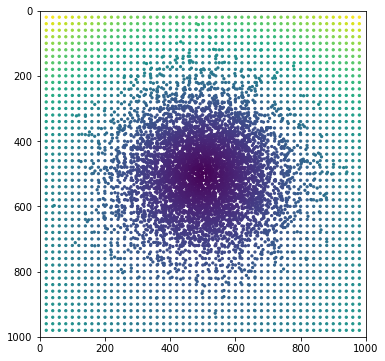

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(X_r, Z_r, c=T_r, s=5)
plt.axis('scaled')
plt.xlim([xmin, xmax])
plt.ylim([zmax, zmin])
plt.show()

In [50]:
def eikonal_ann(nu=50, nl=4, act='tanh', optimizer='adam'):
    # Inputs
    x = sn.Variable('x')
    z = sn.Variable('z')

    # Traveltime
    tau = sn.Functional('tau', [x, z], [nu]*nl, act)
    r = snm.sqrt(x**2 + z**2)
    T = r * tau
    # Eikonal
    
    Tx = snm.diff(T, x)
    Tz = snm.diff(T, z)
#     scal = Tx * x + Tz * z
    Tr2 = Tx**2 + Tz**2
    E = Tr2
    
    # Model and outputs
    outs = [T, E]
    names = ['T', 'E']
    model = sn.SciModel([x, z], [E], optimizer=optimizer)
    outs = {n:v for n, v in zip(names, outs)}
    return model, outs

In [10]:
# Indices except SOURCE POINT for Eikonal, Monotonicity, Laplace etc
eq_ids = np.arange(0, nx*nz, 1, dtype=int)
eq_ids = eq_ids[eq_ids != rav_sid]
b_ids = np.array([rav_sid])

In [46]:
x_data = X.ravel().copy()
z_data = Z.ravel().copy()
v_data = V.ravel().copy()
s_data = 1 / v_data
t_true = (T * vmax / scaler).ravel()

# rx_data = X_r_scaled.ravel()
# rz_data = Z_r_scaled.ravel()
# rv_data = V_r_scaled.ravel()
# rs_data = 1 / rv_data
# rt_true = (T_r * vmax / scaler).ravel()

In [53]:
MODELS, OUTS, HISTORIES, LOSSES = [], [], [], []
optimizer = keras.optimizers.Adam(learning_rate=1e-3, decay=1e-4)
train_kw = dict(x_true = [x_data, z_data],
                y_true = [(eq_ids, s_data**2)], 
                epochs=10000, verbose=1, 
                batch_size=800,
                callbacks=[],
#                 learning_rate=[1e-3, 5e-4, 2.5e-4, 1e-4], 
               )


In [55]:
model, outs = eikonal_ann(nu=50, nl=3, optimizer='adam')

In [56]:
h = model.train(**train_kw)

Epoch 1/10000
2601/2601 [==============================] - 1s 225us/step - loss: nan 
Epoch 2/10000
2601/2601 [==============================] - 0s 15us/step - loss: nan
Epoch 3/10000
2601/2601 [==============================] - 0s 13us/step - loss: nan
Epoch 4/10000
2601/2601 [==============================] - 0s 13us/step - loss: nan
Epoch 5/10000
2601/2601 [==============================] - 0s 15us/step - loss: nan
Epoch 6/10000
2601/2601 [==============================] - 0s 13us/step - loss: nan
Epoch 7/10000
2601/2601 [==============================] - 0s 13us/step - loss: nan
Epoch 8/10000
2601/2601 [==============================] - 0s 13us/step - loss: nan
Epoch 9/10000
2601/2601 [==============================] - 0s 13us/step - loss: nan
Epoch 10/10000
2601/2601 [==============================] - 0s 13us/step - loss: nan
Epoch 11/10000
2601/2601 [==============================] - 0s 13us/step - loss: nan
Epoch 12/10000
2601/2601 [==============================] - 0s 13us/step

KeyboardInterrupt: 

In [39]:
pred = outs['T'].eval([x_data, z_data]).reshape(nx,nz)

(0.0, 50.0, 0.0, 50.0)

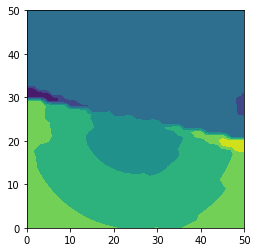

In [40]:
plt.contourf(pred.T)
plt.axis('scaled')

In [83]:
path = '../../data/eikonal/Stability8/'

In [86]:
for i in tqdm(range(0, 10)):
    model, outs = eikonal_ann(optimizer=optimizer)
    print(i)
    h = model.train(**train_kw)
    model.save_weights(path+'weights_'+str(i))
    MODELS.append(model)
    OUTS.append(outs)
    HISTORIES.append(h.history)
    l = np.array(list(h.history.values()))
    print(np.round(l[:-1,-1], 5))
    LOSSES.append(l[0,-1])

0
[0.0115  0.      0.00763]
1



KeyboardInterrupt: 

In [90]:
save(train_kw, path + 'train_kw')
save(HISTORIES, path + 'histories')
save(LOSSES, path + 'losses')

<hr>

In [92]:
path = '../../data/eikonal/Stability'

In [93]:
model, outs = eikonal_ann()
N = 9
PREDS = np.empty((N, 10, nx, nz))
MAE = np.empty((N, 10, nx, nz))
mMAE = np.empty((N, 10))
TRAIN_KW = []
HIST = []
for i in tqdm(range(N)):
    TRAIN_KW.append(load(path + str(i) + '/train_kw'))
    HIST.append(load(path + str(i) + '/histories'))
    for j in range(10):
        model.load_weights(path + str(i) + '/weights_' + str(j))
        t_pred = outs['T'].eval([x_data, z_data])
        err = np.abs(t_pred - t_true) / vmax * scaler
        MAE[i,j] = err.reshape(nx,nz)
        mMAE[i,j] = np.mean(MAE[i,j])
        PREDS[i,j] = t_pred.reshape(nx,nz)

OSError: Unable to open file (unable to open file: name = '../../data/eikonal/Stability8/weights_3', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [97]:
sort_ind = np.argsort(mMAE, axis=-1)
minmidmax = sort_ind[:, [0, 4, -1]]

IndexError: list index out of range

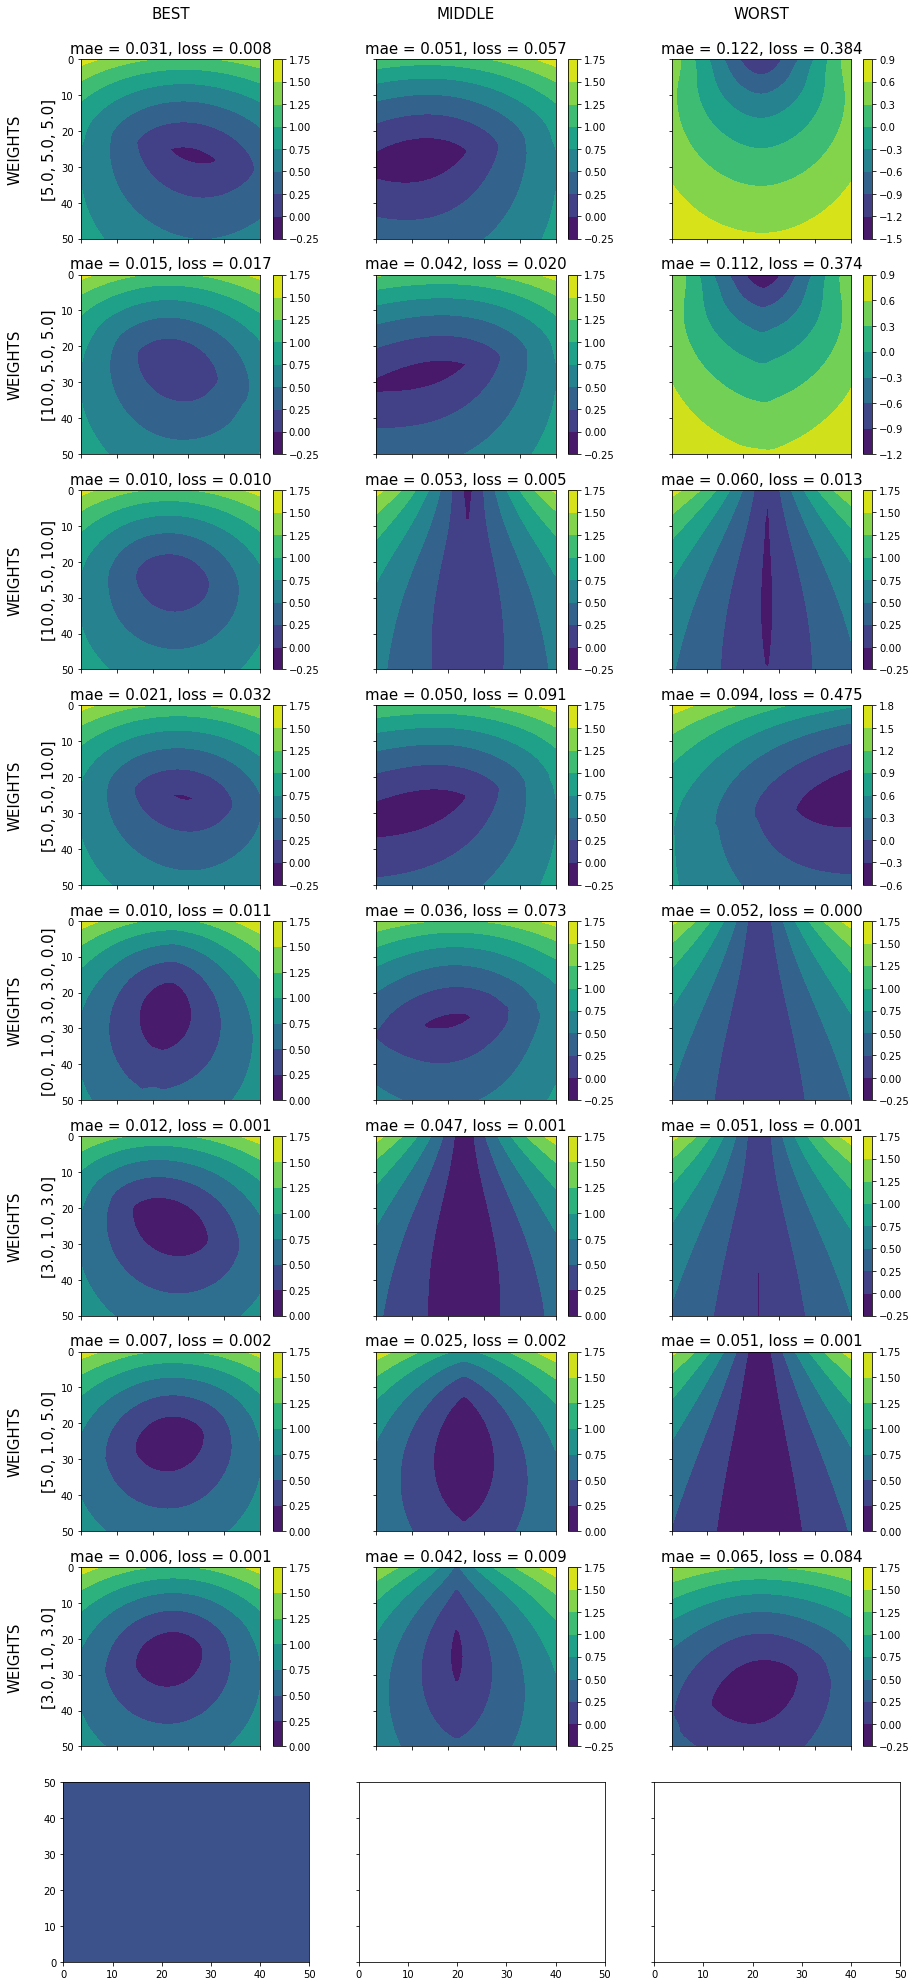

In [98]:
fig, axes = plt.subplots(ncols=3, nrows=N, sharex='col', sharey='row', figsize=(15, 35))

for (i,j), ax in np.ndenumerate(axes):
    im = ax.contourf(PREDS[i,minmidmax[i,j]].T)
    name = ['BEST\n\n', 'MIDDLE\n\n', 'WORST\n\n']
    ax.set_title(name[j]*(i==0) + 'mae = {0:.3f}, loss = {1:.3f}'.format(mMAE[i,minmidmax[i,j]], 
                                                                         HIST[i][minmidmax[i,j]]['loss'][-1]),
                 fontsize=15)
    if j == 0:
        ax.set_ylabel('WEIGHTS\n\n' + str(TRAIN_KW[i]['target_weights']), fontsize=15)
    ax.set_ylim([nz-1, 0])
    ax.axis('scaled')
    plt.colorbar(mappable=im, ax=ax)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\ProgramData\A

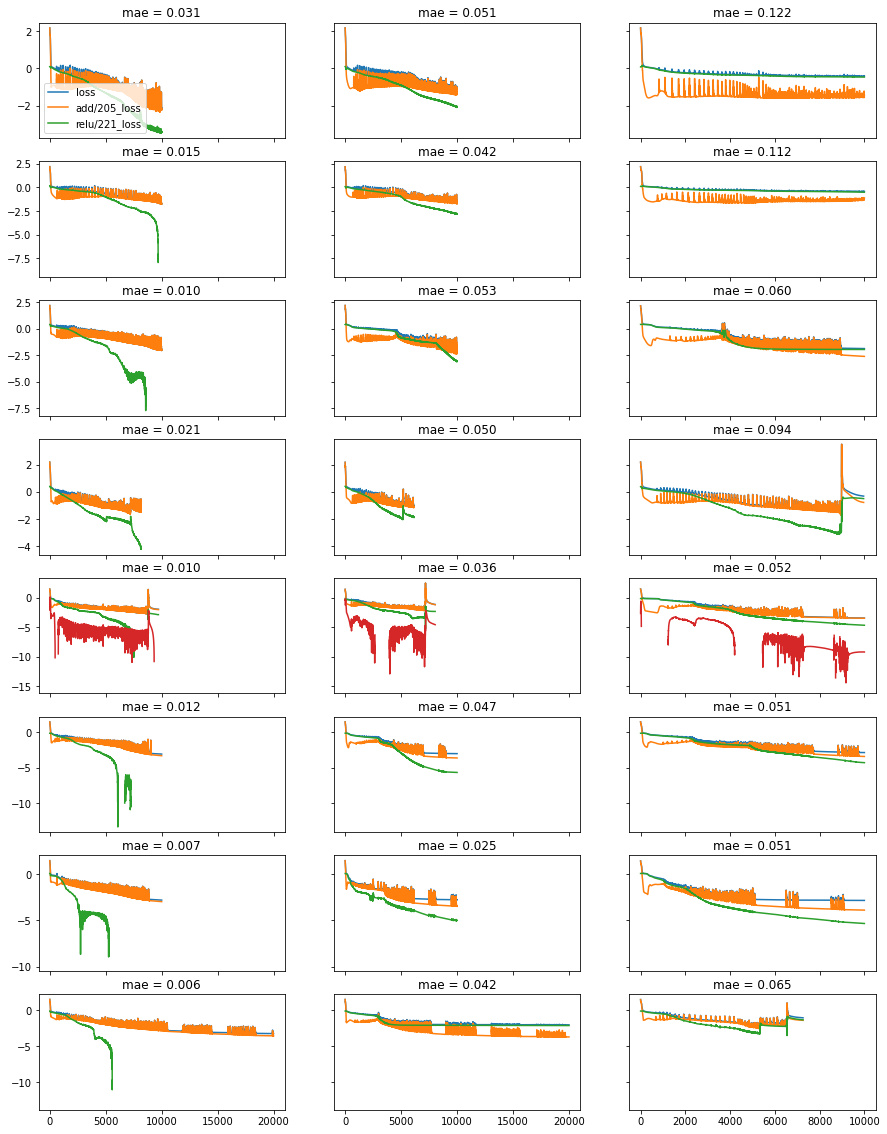

In [98]:
fig, axes = plt.subplots(ncols=3, nrows=N, sharex='col', sharey='row', figsize=(15, 20))

for (i,j), ax in np.ndenumerate(axes):
    for k, v in HIST[i][minmidmax[i,j]].items():
        if k != 'lr' and k != 'Traveltime_loss':
            ax.plot(np.log10(v), label=k)
    ax.set_title('mae = {0:.3f}'.format(mMAE[i,minmidmax[i,j]]))
    j += 1
axes[0,0].legend(loc='lower left')
plt.show()

In [22]:
losses = list(h.history.values())

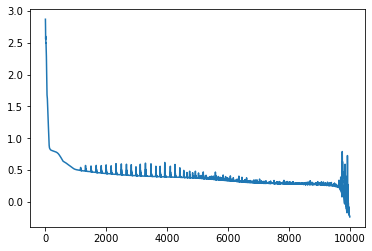

In [23]:
plt.plot(np.log10(losses[0]), )